# Autoencoder Performance by Growth Rate

In this notebook, we investigate the performance of a basic autoencoder model in terms of whether or not neighbors become random in the high-dimensional space. We start by loading the necessary libraries.

In [1]:
# Handling arrays
import numpy as np

# Handling data frames
import pandas as pd

# neural networks in Python
import torch
from torch import nn

# plotting
import matplotlib.pyplot as plt

%matplotlib inline

We define our experiment parameters.

In [2]:
ntimes = 100 # number of noise replicates to investigate dimred performance
npoints = 25 # number of points in our ground truth data set to be investigated
maxdim = 10000 # maximal dimension of the data set to be investigated
dims = np.round(np.exp(np.linspace(np.log(2), np.log(maxdim), num=10))).astype("int") # dimensions to study
a = 1.25 # magnitude of noise: per dimension we sample noise uniformly from [-a, a]
alphas = np.append(np.arange(2, 7), np.inf) # factors controling the growth rate of the ground truth diameters

We construct the ground truth data sets according to the various growth rates.

In [3]:
t = np.linspace(0, 1, num=npoints)
datasets = []
for idx, alpha in enumerate(alphas):
    factor = np.ones(maxdim) if alpha == np.inf else (np.arange(maxdim) + 1)**(-1 / alpha)
    datasets.append(np.transpose(np.tile(t, (maxdim, 1))) * np.tile(factor, (npoints, 1)))

We define an autoencoder model.

In [4]:
class autoencoder(nn.Module):

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=1.0)        
            nn.init.zeros_(m.bias)

    def __init__(self, input_dim, encoding_dim):
        super(autoencoder, self).__init__()
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 24),
            nn.Tanh(),
            nn.Linear(24, 6),
            nn.Tanh(),
            nn.Linear(6, self.encoding_dim),
            nn.Tanh())
        self.decoder = nn.Sequential(
            nn.Linear(self.encoding_dim, 6),
            nn.Tanh(), 
            nn.Tanh(),
            nn.Linear(6, 24),
            nn.Linear(24, self.input_dim))
        
        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
def autoencode(X, encoding_dim, num_epochs=2000, learning_rate=1e-3, eps=1e-07):
    X = torch.tensor(X).type(torch.float)
    model = autoencoder(input_dim=X.shape[1], encoding_dim=encoding_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=eps)
    
    for epoch in range(num_epochs):
        output = model(X)
        loss = criterion(output, X)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    Y = model.encoder(X).detach().numpy()
    
    return(Y)

We view the magnitude of noise and autoencoder embedding for an example dataset.

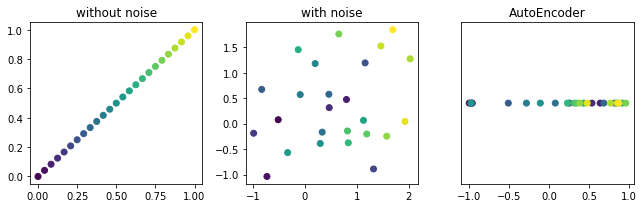

In [5]:
np.random.seed(17)
torch.manual_seed(17)

idx = 5
XN = datasets[idx][:,:2] + a * (2 * np.random.rand(npoints, 2) - 1)
Y = autoencode(XN, encoding_dim=1)
Y = np.concatenate([Y, np.zeros([Y.shape[0], 1])], axis=1)

if np.corrcoef(Y[:,0], t)[0, 1] < 0:
    Y = np.flip(Y, axis=0)
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
axes[0].scatter(datasets[idx][:,0], datasets[idx][:,1], c=t)
axes[0].title.set_text("without noise")
axes[1].scatter(XN[:,0], XN[:,1], c=t)
axes[1].title.set_text("with noise")
axes[2].scatter(Y[:,0], Y[:,1], c=t)
axes[2].title.set_text("AutoEncoder")
axes[2].get_yaxis().set_visible(False)
fig.tight_layout()

We measure the autoencoder performance by dimensionality and growth rate.

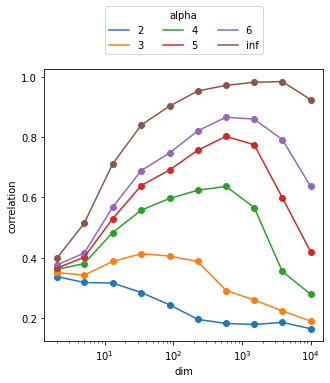

In [6]:
cor_auto = np.zeros([len(dims), len(alphas)])

for idx in range(ntimes):
    
    print("progress: " + str(round(100 * idx / ntimes, 2)).ljust(5, "0") + "%", end="\r")
    
    N = a * (2 * np.random.rand(npoints, maxdim) - 1)
    
    for alpha_idx, alpha in enumerate(alphas):
        
            XN = datasets[alpha_idx] + N
            
            for dim_idx, dim in enumerate(dims):
                
                Y = autoencode(XN[:,:dim], 1)
                cor = np.max([np.corrcoef(Y[:,0], t)[0, 1], np.corrcoef(np.flip(Y[:,0], axis=0), t)[0, 1]])
                cor_auto[dim_idx, alpha_idx] += cor
                
cor_auto /= ntimes

print("progress: 100.0%", end="\r")


fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel("dim")
ax.set_ylabel("correlation")
ax.set_xscale("log")

for idx, alpha in enumerate(alphas):
    
    alpha_label = int(alpha) if alpha != np.inf else alpha
    ax.plot(dims, cor_auto[:,idx], label=alpha_label)
    ax.scatter(dims, cor_auto[:,idx])
    
ax.legend(title="alpha", loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.25))

We modify the style of the results and save as csv for plotting in R.

In [7]:
cor_auto_df = np.zeros([cor_auto.shape[0] * cor_auto.shape[1], 3])
idx = 0
for idx1, alpha in enumerate(alphas):
    for idx2, dim in enumerate(dims):
        cor_auto_df[idx,:] = [alpha, dim, cor_auto[idx2, idx1]]
        idx += 1 
        
cor_auto_df = pd.DataFrame(cor_auto_df)
cor_auto_df.columns = ["alpha", "dim", "cor"]
cor_auto_df.to_csv("../Results/Alpha/AUTO.csv")